In [2]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import RepeatedStratifiedKFold

In [3]:
collman15v2 = pd.read_csv('data/collman15v2.csv')
collman14v2 = pd.read_csv('data/collman14v2.csv')

In [4]:
collman14v2 = collman14v2[collman14v2.total != 0]

In [5]:
columns = ['GABA', 'GAD', 'gephyrin', 'NR1', 'PSD', 'Synapsin', 'VGluT1', 'location']

In [6]:
#Create new dataframes using columns above
collman15v2 = collman15v2[columns]
collman14v2 = collman14v2[columns]

In [7]:
collman15v2.head()

,GABA,GAD,gephyrin,NR1,PSD,Synapsin,VGluT1,location
0,0.062382,1.986366,0.385097,0.190005,1.732728,1.001573,0.620783,on_synapse
1,0.077235,1.237165,0.359511,0.330757,1.999066,0.934644,0.289654,on_synapse
2,0.005923,0.371813,0.120297,0.042547,0.033503,0.296893,0.207308,on_synapse
3,0.147710,1.061725,0.306219,0.203209,0.858445,0.687535,0.453936,on_synapse
4,0.096643,0.999047,0.463625,0.307832,0.463181,0.976970,0.307580,on_synapse


In [8]:
collman14v2.head()

,GABA,GAD,gephyrin,NR1,PSD,Synapsin,VGluT1,location
0,0.014463,0.041894,0.157161,0.077249,0.455805,0.060186,0.110704,on_synapse
1,0.029084,0.058346,0.070150,0.064481,0.625653,0.041553,0.091067,on_synapse
3,0.044822,0.041860,0.875676,0.061351,0.035623,0.029494,0.063645,on_synapse
4,0.836592,0.848743,0.436456,0.149300,0.028304,0.262342,0.086698,on_synapse
5,0.019666,0.040624,0.051759,0.074537,0.252298,0.144212,0.036364,on_synapse


In [9]:
def compute_lda_qda(dataset_1, dataset_2):
    length = len(dataset_1.columns) - 1
    pairs = list(itertools.combinations(range(length), 2))

    shape = (length, length)

    #Matrix for keeping accuracy scores with shape (length, length)
    lda_in_sample_score_matrix = np.ones(shape)
    lda_out_sample_score_matrix = np.ones(shape)
    qda_in_sample_score_matrix = np.ones(shape)
    qda_out_sample_score_matrix = np.ones(shape)
    
    #Compute scores for LDA and QDA using collman14v2 as training data and collman15v2 as test data
    for i, j in pairs:
        lda_in_sample_scores = []
        lda_out_sample_scores = []
        qda_in_sample_scores = []
        qda_out_sample_scores = []

        lda = LinearDiscriminantAnalysis()
        qda = QuadraticDiscriminantAnalysis()

        X = dataset_1.iloc[:, i:j+1].values #Data
        y = dataset_1.iloc[:, -1].values #Labels

        X2 = dataset_2.iloc[:, i:j+1].values
        y2 = dataset_2.iloc[:, -1].values

        skf = RepeatedStratifiedKFold(n_splits=3, random_state=np.random.RandomState()) # 66% train, 33% test
        for train, test in skf.split(X, y):
            lda.fit(X[train], y[train])
            qda.fit(X[train], y[train])

            lda_in_sample_scores.append(lda.score(X[test], y[test]))
            lda_out_sample_scores.append(lda.score(X2, y2))
            qda_in_sample_scores.append(qda.score(X[test], y[test]))
            qda_out_sample_scores.append(qda.score(X2, y2))

        skf = RepeatedStratifiedKFold(n_splits=3, random_state=np.random.RandomState()) # 33% train, 66% test
        for test, train in skf.split(X, y):
            lda.fit(X[train], y[train])
            qda.fit(X[train], y[train])

            lda_in_sample_scores.append(lda.score(X[test], y[test]))
            lda_out_sample_scores.append(lda.score(X2, y2))
            qda_in_sample_scores.append(qda.score(X[test], y[test]))
            qda_out_sample_scores.append(qda.score(X2, y2))

        skf = RepeatedStratifiedKFold(n_splits=2, random_state=np.random.RandomState()) # 50% train, 50% test
        for train, test in skf.split(X, y):
            lda.fit(X[train], y[train])
            qda.fit(X[train], y[train])

            lda_in_sample_scores.append(lda.score(X[test], y[test]))
            lda_out_sample_scores.append(lda.score(X2, y2))
            qda_in_sample_scores.append(qda.score(X[test], y[test]))
            qda_out_sample_scores.append(qda.score(X2, y2))

        lda_in_sample_score_matrix[((i, j), (j, i))] = np.mean(lda_in_sample_scores)
        lda_out_sample_score_matrix[((i, j), (j, i))] = np.mean(lda_out_sample_scores)

        qda_in_sample_score_matrix[((i, j), (j, i))] = np.mean(qda_in_sample_scores)
        qda_out_sample_score_matrix[((i, j), (j, i))] = np.mean(qda_out_sample_scores)
    
    for i in range(length):
        lda_in_sample_scores = []
        lda_out_sample_scores = []
        qda_in_sample_scores = []
        qda_out_sample_scores = []

        lda = LinearDiscriminantAnalysis()
        qda = QuadraticDiscriminantAnalysis()

        X = dataset_1.iloc[:, i].values.reshape(-1, 1) #Data
        y = dataset_1.iloc[:, -1].values #Labels

        X2 = dataset_2.iloc[:, i].values.reshape(-1, 1)
        y2 = dataset_2.iloc[:, -1].values

        skf = RepeatedStratifiedKFold(n_splits=3, random_state=np.random.RandomState()) # 66% train, 33% test
        for train, test in skf.split(X, y):
            lda.fit(X[train], y[train])
            qda.fit(X[train], y[train])

            lda_in_sample_scores.append(lda.score(X[test], y[test]))
            lda_out_sample_scores.append(lda.score(X2, y2))
            qda_in_sample_scores.append(qda.score(X[test], y[test]))
            qda_out_sample_scores.append(qda.score(X2, y2))

        skf = RepeatedStratifiedKFold(n_splits=3, random_state=np.random.RandomState()) # 33% train, 66% test
        for test, train in skf.split(X, y):
            lda.fit(X[train], y[train])
            qda.fit(X[train], y[train])

            lda_in_sample_scores.append(lda.score(X[test], y[test]))
            lda_out_sample_scores.append(lda.score(X2, y2))
            qda_in_sample_scores.append(qda.score(X[test], y[test]))
            qda_out_sample_scores.append(qda.score(X2, y2))

        skf = RepeatedStratifiedKFold(n_splits=2, random_state=np.random.RandomState()) # 50% train, 50% test
        for train, test in skf.split(X, y):
            lda.fit(X[train], y[train])
            qda.fit(X[train], y[train])

            lda_in_sample_scores.append(lda.score(X[test], y[test]))
            lda_out_sample_scores.append(lda.score(X2, y2))
            qda_in_sample_scores.append(qda.score(X[test], y[test]))
            qda_out_sample_scores.append(qda.score(X2, y2))

        lda_in_sample_score_matrix[(i, i)] = np.mean(lda_in_sample_scores)
        lda_out_sample_score_matrix[(i, i)] = np.mean(lda_out_sample_scores)

        qda_in_sample_score_matrix[(i, j)] = np.mean(qda_in_sample_scores)
        qda_out_sample_score_matrix[(i, j)] = np.mean(qda_out_sample_scores)
        
    return lda_in_sample_score_matrix, lda_out_sample_score_matrix, \
            qda_in_sample_score_matrix, qda_out_sample_score_matrix

In [17]:
# Generate a mask for the upper triangle - for ploting later
mask = np.zeros_like(qda_out_sample, dtype=np.bool)
mask[np.triu_indices_from(mask, k=1)] = True

### Run single channel LDA and QDA using collman15v2 as training data and collman14v2 as test data

In [11]:
lda_in_sample, lda_out_sample, qda_in_sample, qda_out_sample = compute_lda_qda(collman15v2, collman14v2)

In [14]:
qda_out_sample_score_df = pd.DataFrame(qda_out_sample, index=columns[:-1], columns=columns[:-1])

lda_out_sample_score_df = pd.DataFrame(lda_out_sample, index=columns[:-1], columns=columns[:-1])

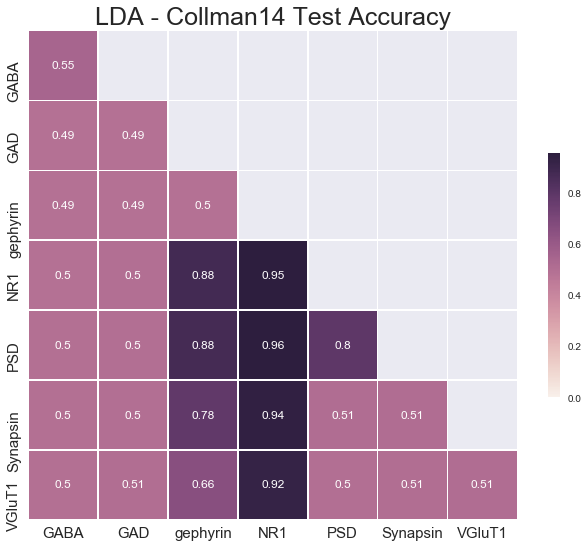

In [24]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(lda_out_sample_score_df, mask=mask, vmin=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

ax.set_title('LDA - Collman14 Test Accuracy', fontdict={'fontsize': 25})
#ax.set_ylabel('Biomarker', fontdict={'fontsize': 15}, labelpad=10)
#ax.set_xlabel('Component Number', fontdict={'fontsize': 15}, labelpad=10)
ax.set_xticklabels(columns[:-1], fontdict={'fontsize': 15})
ax.set_yticklabels(columns[:-1][::-1], fontdict={'fontsize': 15})

plt.show()

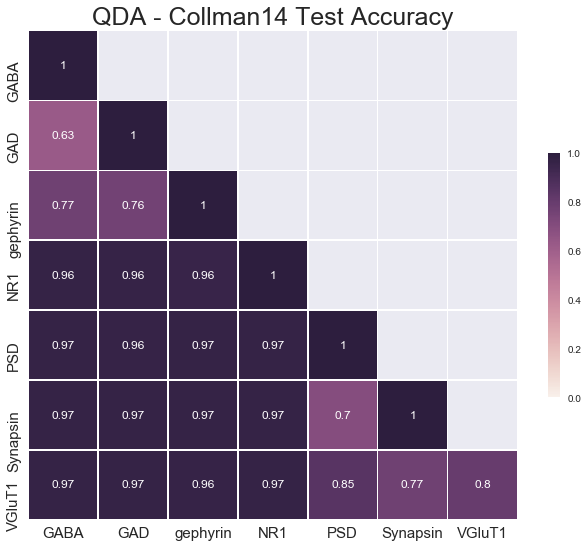

In [25]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(qda_out_sample_score_df, mask=mask, vmin=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

ax.set_title('QDA - Collman14 Test Accuracy', fontdict={'fontsize': 25})
#ax.set_ylabel('Biomarker', fontdict={'fontsize': 15}, labelpad=10)
#ax.set_xlabel('Component Number', fontdict={'fontsize': 15}, labelpad=10)
ax.set_xticklabels(columns[:-1], fontdict={'fontsize': 15})
ax.set_yticklabels(columns[:-1][::-1], fontdict={'fontsize': 15})

plt.show()

### Run single channel LDA and QDA using collman15v2 as training data and collman14v2 as test data

In [26]:
lda_in_sample, lda_out_sample, qda_in_sample, qda_out_sample = compute_lda_qda(collman14v2, collman15v2)

In [27]:
qda_out_sample_score_df = pd.DataFrame(qda_out_sample, index=columns[:-1], columns=columns[:-1])

lda_out_sample_score_df = pd.DataFrame(lda_out_sample, index=columns[:-1], columns=columns[:-1])

In [28]:
pd.DataFrame(lda_in_sample, index=columns[:-1], columns=columns[:-1])

,GABA,GAD,gephyrin,NR1,PSD,Synapsin,VGluT1
GABA,0.905933,0.950007,0.943994,0.949075,0.949518,0.950822,0.950816
GAD,0.950007,0.948770,0.942642,0.948732,0.949043,0.950542,0.950401
gephyrin,0.943994,0.942642,0.930540,0.944797,0.946701,0.947535,0.947764
NR1,0.949075,0.948732,0.944797,0.948162,0.948027,0.949125,0.948779
PSD,0.949518,0.949043,0.946701,0.948027,0.878806,0.910188,0.930295
Synapsin,0.950822,0.950542,0.947535,0.949125,0.910188,0.899234,0.930406
VGluT1,0.950816,0.950401,0.947764,0.948779,0.930295,0.930406,0.929360


In [29]:
pd.DataFrame(qda_in_sample, index=columns[:-1], columns=columns[:-1])

,GABA,GAD,gephyrin,NR1,PSD,Synapsin,VGluT1
GABA,1.000000,0.977403,0.975446,0.973613,0.972750,0.972630,0.974843
GAD,0.977403,1.000000,0.975777,0.973570,0.972761,0.972147,0.979123
gephyrin,0.975446,0.975777,1.000000,0.969409,0.970012,0.968470,0.955747
NR1,0.973613,0.973570,0.969409,1.000000,0.963293,0.966017,0.968378
PSD,0.972750,0.972761,0.970012,0.963293,1.000000,0.941159,0.877846
Synapsin,0.972630,0.972147,0.968470,0.966017,0.941159,1.000000,0.953451
VGluT1,0.972454,0.972697,0.969927,0.971111,0.967423,0.965219,0.957173


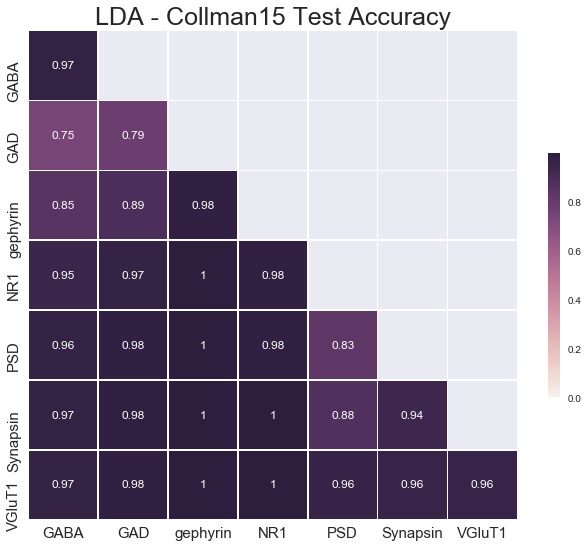

In [32]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(lda_out_sample_score_df, mask=mask, vmin=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

ax.set_title('LDA - Collman15 Test Accuracy', fontdict={'fontsize': 25})
#ax.set_ylabel('Biomarker', fontdict={'fontsize': 15}, labelpad=10)
#ax.set_xlabel('Component Number', fontdict={'fontsize': 15}, labelpad=10)
ax.set_xticklabels(columns[:-1], fontdict={'fontsize': 15})
ax.set_yticklabels(columns[:-1][::-1], fontdict={'fontsize': 15})

plt.show()

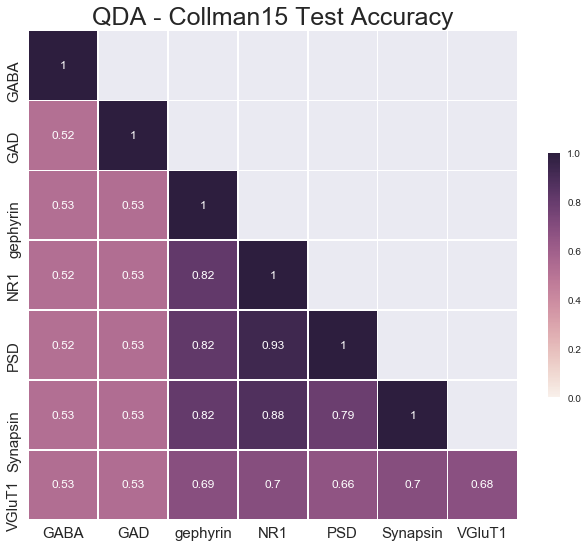

In [33]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(qda_out_sample_score_df, mask=mask, vmin=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

ax.set_title('QDA - Collman15 Test Accuracy', fontdict={'fontsize': 25})
#ax.set_ylabel('Biomarker', fontdict={'fontsize': 15}, labelpad=10)
#ax.set_xlabel('Component Number', fontdict={'fontsize': 15}, labelpad=10)
ax.set_xticklabels(columns[:-1], fontdict={'fontsize': 15})
ax.set_yticklabels(columns[:-1][::-1], fontdict={'fontsize': 15})

plt.show()